Continuing the results in CNVkit, let's parse everything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/simplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
# fid = open('/home/sudregp/data/multiplex_simplex/samples_simplex_all.txt', 'r')
# exclude_list = [line.rstrip() for line in fid]
# fid.close()

# no controls/affected pair for comparison
exclude_list = ['CLIA_400165', 'CLIA_400164', 'CLIA_400155', 'CLIA_400146',
                'CLIA_400145', 'CLIA_400126', 'CLIA_400207', 'CLIA_400208',
                'CLIA_400209']
# missing one parent
exclude_list += ['CLIA_400169', 'CLIA_400168']
# family 9030
exclude_list += ['CCGO_800978', 'CCGO_800977', 'CCGO_800976', 'CCGO_800979',
                 'CCGO_800980', 'CLIA_400067']

trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and
            sid not in samples and
            (sid not in exclude_list or fa not in exclude_list or mo not in exclude_list)):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)
good_kids = kids

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 84
Unique families: 19
Unique children: 46


In [24]:
def classify_cnvs(cnvs, trios):
    inherited = {}
    denovo = {}
    for trio in trios:
        inherited[trio['child']] = []
        denovo[trio['child']] = []

    # need to filter in chr and type first because ranges repeat for every chr,
    # and inheritance is only true for the same type of CNV
    for chr in ['chr%d' % d for d in range(1, 23)]:
        for cnvtype in ['dup', 'del']:
            for trio in trios:
                kid = [cnv for cnv in cnvs[trio['child']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                dad = [cnv for cnv in cnvs[trio['father']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                mom = [cnv for cnv in cnvs[trio['mother']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                for cnv in kid:
                    is_inherited = False
                    # if CNV start is not within any parents boundary AND
                    #         CNV end is not within any parents boundary
                    # it's denovo
                    for pcnv in dad + mom:
                        if ((cnv[1] >= pcnv[1] or cnv[1] <= pcnv[2]) or
                            (cnv[2] >= pcnv[1] or cnv[2] <= pcnv[2])):
                            is_inherited = True
                    if is_inherited:
                        inherited[trio['child']].append(cnv)
                    else:
                        denovo[trio['child']].append(cnv)
    return denovo, inherited


def write2plink(data, fname, trios):
    fid = open(fname, 'w')
    fid.write('FID\tIID\tCHR\tBP1\tBP2\tTYPE\tSCORE\tSITE\n')
    for sample, cnvs in data.iteritems():
        famid = [trio['famid'] for trio in trios if trio['child'] == sample][0]
        for cnv in cnvs:
            ch = cnv[0].replace('chr', '')
            if cnv[3] == 'del':
                cnvt = '1'
            else:
                cnvt = '3'
            if len(cnv) > 4:
                score = cnv[5]
                site = cnv[4]
            else:
                score, site = ['0', '0']
            fid.write('\t'.join([famid, sample, ch, cnv[1], cnv[2], cnvt,
                                 score, site]) + '\n')
    fid.close()

In [25]:
data_dir = '/data/sudregp/cnv/cnvkit/'

cnvs = {}
for sample in samples:
    cnvs[sample] = []
    df = pd.read_table('%s/flat/%s.segmetrics.call.cns' % (data_dir, sample))
    df = df[df.cn != 2]
    for row in df.itertuples():
        if row.cn > 2:
            cnvtype = 'dup'
        else:
            cnvtype = 'del'
        cnvs[sample].append([row.chromosome, str(row.start), str(row.end),
                             cnvtype])

dn, inh = classify_cnvs(cnvs, trios)
write2plink(dn, data_dir + '/denovo.cnv', trios)
write2plink(inh, data_dir + '/inherited.cnv', trios)
tmp_cnv = {}
for sample in cnvs.iterkeys():
    if sample in affected + controls:
        tmp_cnv[sample] = cnvs[sample]
write2plink(tmp_cnv, data_dir + '/all.cnv', trios)

Then run PLINK:

In [1]:
#terminal
module load plink/1.07
cd /data/sudregp/cnv/cnvkit/
cat ../penncnv/wellknown_region_hg19 > bad_regions.list
cp ../penncnv/genes.txt ../penncnv/hg19_allenBrainGene_trimmed.txt ../penncnv/glist-hg19 .

for cnvtype in denovo inherited all; do
    cnvname=${cnvtype}.cnv
    plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype};
    
    # remove bad regions
    plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
        --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
        --cnv-write --out ${cnvtype}_clean
    plink --cnv-list ${cnvtype}_clean.cnv --cnv-make-map --noweb --1 \
        --out ${cnvtype}_clean
    
    for qc in '' '_clean'; do
        cnvname=${cnvtype}${qc}.cnv
        # whole burden
        plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-check-no-overlap --out ${cnvtype}${qc}_burden;
        # gene sets
        plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset genes.txt --out ${cnvtype}${qc}_genes;
        plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset hg19_allenBrainGene_trimmed.txt \
            --out ${cnvtype}${qc}_brainGenes;
        # subtypes only
        for sub in del dup; do
            plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-${sub} --out ${cnvtype}${qc}_${sub}Burden;
            # gene sets
            plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --cnv-${sub} \
                --out ${cnvtype}${qc}_${sub}Genes;
            plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                --out ${cnvtype}${qc}_${sub}BrainGenes;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo.log ]
Analysis started: Thu Mar  1 15:00:41 2018

Options in effect:
	--cnv-list denovo.cnv
	--cnv-make-map
	--noweb
	--out denovo


Reading segment list (CNVs) from [ denovo.cnv ]
Writing new MAP file to [ denovo.cnv.map ]
Wrote 1057 unique positions to file

Analysis finished: Thu Mar  1 15:00:41 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|------

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_brainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo.cnv ]
Writing back list to intersected regions to [ denovo_brainGenes.reg ]
565 mapped to a person, of which 565 passed filters
70 intersected with one or more specified region
70 of 565 mapped as valid segments
 CopyN Case/Control
     1      17 / 24
     3       6 / 23

Writing per-individual summary to [ denovo_brainGenes.cnv.indiv ]
Writing positional summary to [ denovo_brainGenes.cnv.summary ]

Analysis finished: Thu Mar  1 15:00:53 2018


@----------------------------------------------------------@
|        PLINK!       |    

|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_dupGenes.log ]
Analysis started: Thu Mar  1 15:00:54 2018

Options in effect:
	--map denovo.cnv.map
	--fam ../simplex.ped
	--cnv-list denovo.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-dup
	--out denovo_dupGenes

Reading marker information from [ denovo.cnv.map ]
1057 (of 1057) markers to be included from [ denovo.cnv.map ]
Reading individual information from [ ../simplex.ped ]
Reading pedigree information from [ ../simplex.ped ] 
99 individuals read from [ ../simplex.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=una

	--cnv-list denovo_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out denovo_clean_brainGenes

Reading marker information from [ denovo_clean.cnv.map ]
269 (of 269) markers to be included from [ denovo_clean.cnv.map ]
Reading individual information from [ ../simplex.ped ]
Reading pedigree information from [ ../simplex.ped ] 
99 individuals read from [ ../simplex.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_clean_brainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_clean.cnv ]
Writing back list to i

99 individuals read from [ ../simplex.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_clean.cnv ]
122 mapped to a person, of which 77 passed filters
77 of 122 mapped as valid segments
 CopyN Case/Control
     3      26 / 51

Writing per-individual summary to [ denovo_clean_dupBurden.cnv.indiv ]
Writing positional summary to [ denovo_clean_dupBurden.cnv.summary ]

Analysis finished: Thu Mar  1 15:00:55 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/

Wrote 468 unique positions to file

Analysis finished: Thu Mar  1 15:01:28 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_burden.log ]
Analysis started: Thu Mar  1 15:01:28 2018

Options in effect:
	--map inherited.cnv.map
	--fam ../simplex.ped
	--cnv-list inherited.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out inherited_burden

Reading marker information from [ inherited.cnv.map ]
1743 (of 1743) markers to be included from [ inherited.cnv.map ]
Reading individual in

	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out inherited_delGenes

Reading marker information from [ inherited.cnv.map ]
1743 (of 1743) markers to be included from [ inherited.cnv.map ]
Reading individual information from [ ../simplex.ped ]
Reading pedigree information from [ ../simplex.ped ] 
99 individuals read from [ ../simplex.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited.cnv ]
Writing back list to intersected regions to [ inherited_delGenes.reg ]
1777 mapped to a person, of which 514 passed filters
495 intersected with one or more specified region
49

21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited.cnv ]
Writing back list to intersected regions to [ inherited_dupBrainGenes.reg ]
1777 mapped to a person, of which 1263 passed filters
175 intersected with one or more specified region
175 of 1777 mapped as valid segments
 CopyN Case/Control
     3     63 / 112

Writing per-individual summary to [ inherited_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_dupBrainGenes.cnv.summary ]

Analysis finished: Thu Mar  1 15:01:33 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|-----------


Writing per-individual summary to [ inherited_clean_delBurden.cnv.indiv ]
Writing positional summary to [ inherited_clean_delBurden.cnv.summary ]

Analysis finished: Thu Mar  1 15:01:34 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_clean_delGenes.log ]
Analysis started: Thu Mar  1 15:01:34 2018

Options in effect:
	--map inherited_clean.cnv.map
	--fam ../simplex.ped
	--cnv-list inherited_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions

|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_clean_dupBrainGenes.log ]
Analysis started: Thu Mar  1 15:01:35 2018

Options in effect:
	--map inherited_clean.cnv.map
	--fam ../simplex.ped
	--cnv-list inherited_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out inherited_clean_dupBrainGenes

Reading marker information from [ inherited_clean.cnv.map ]
468 (of 468) markers to be included from [ inherited_clean.cnv.map ]
Reading individual information from [ ../simplex.ped ]
Reading pedigree information fr

99 individuals read from [ ../simplex.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all.cnv ]
Writing back list to intersected regions to [ all_genes.reg ]
2717 mapped to a person, of which 2717 passed filters
2645 intersected with one or more specified region
2645 of 2717 mapped as valid segments
 CopyN Case/Control
     1    352 / 620
     3   665 / 1008

Writing per-individual summary to [ all_genes.cnv.indiv ]
Writing positional summary to [ all_genes.cnv.summary ]

Analysis finished: Thu Mar  1 15:02:32 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009  

 CopyN Case/Control
     1    117 / 194

Writing per-individual summary to [ all_delBrainGenes.cnv.indiv ]
Writing positional summary to [ all_delBrainGenes.cnv.summary ]

Analysis finished: Thu Mar  1 15:02:34 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_dupBurden.log ]
Analysis started: Thu Mar  1 15:02:34 2018

Options in effect:
	--map all.cnv.map
	--fam ../simplex.ped
	--cnv-list all.cnv
	--noweb
	--1
	--cnv-dup
	--out all_dupBurden

Reading marker information from [ a

	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--out all_clean_genes

Reading marker information from [ all_clean.cnv.map ]
775 (of 775) markers to be included from [ all_clean.cnv.map ]
Reading individual information from [ ../simplex.ped ]
Reading pedigree information from [ ../simplex.ped ] 
99 individuals read from [ ../simplex.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_clean.cnv ]
Writing back list to intersected regions to [ all_clean_genes.reg ]
700 mapped to a person, of which 700 passed filters
699 intersected with one or more specified region
699 of 700 mapped as valid segments
 CopyN Case/Control
     1  

Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_clean_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_clean.cnv ]
Writing back list to intersected regions to [ all_clean_delBrainGenes.reg ]
700 mapped to a person, of which 364 passed filters
204 intersected with one or more specified region
204 of 700 mapped as valid segments
 CopyN Case/Control
     1     72 / 132

Writing per-individual summary to [ all_clean_delBrainGenes.cnv.indiv ]
Writing positional summary to [ all_clean_delBrainGenes.cnv.summary ]

Analysis finished: Thu Mar  1 15:02:38 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU Genera

In [3]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [4]:
import glob

data_dir = '/home/sudregp/data/cnv/cnvkit/'
files = glob.glob(data_dir + '/denovo_clean*.indiv')
files.sort()
for f in files:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 10033, 10182
Best protected: 10131, 10094, 10448, 1976, 10164, 10215


Best disrupted: 855, 1892, 10153, 10033, 1895, 10128
Best protected: 10131, 10448, 10090, 10182, 10094, 10178, 1976, 10197, 10406, 10164, 10215


Best disrupted: 10033, 10131, 10182
Best protected: 10448, 10090, 10094, 1976, 10215


Best disrupted: 855, 10033, 10128
Best protected: 10131, 10448, 10090, 10094, 10178, 10197, 1976, 10164, 10215


Best disrupted: 855, 10033, 10128
Best protected: 10131, 10448, 10090, 10094, 10178, 10197, 1976, 10164, 10215


Best disrupted: 10090
Best protected: 10131, 10094, 1976, 10164


Best disrupted: 855, 1892, 10153, 1895
Best protected: 10131, 10182, 10448, 10090, 10178, 10406, 10094, 1976, 10215


Best disrupted: 855, 1892, 10153, 1895
Best protected: 10131, 10182, 10448, 10090, 10178, 10406, 10094, 1976, 10215


Best disrupted: 855, 1892, 10153, 10033, 1895, 10128
Best protected: 10131, 10448, 10090, 10182, 10094, 10178, 1976, 10197, 10406, 10164, 10215


I might need to do some CNV merging here... some of them might be quite close together.

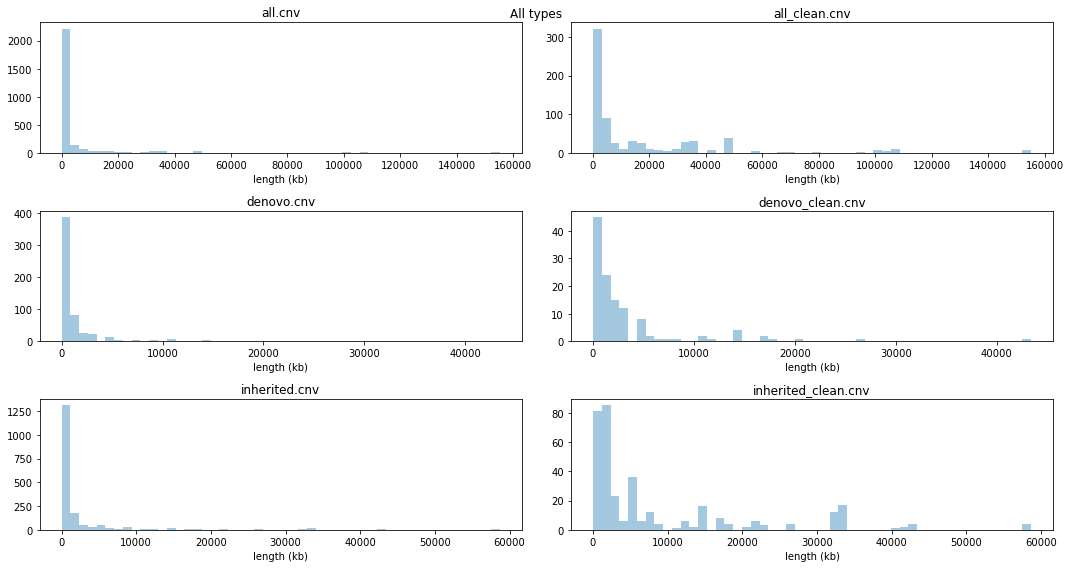

In [5]:
data_dir = '/home/sudregp/data/cnv/cnvkit/'
files = glob.glob(data_dir + '/*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.suptitle('All types')
plt.tight_layout()

In [6]:
%%bash
cd ~/data/cnv/cnvkit
cat denovo_clean.cnv | awk '{ if (($5-$4)/1000 > 20000) { print $_, ($5-$4)/1000 } }'

  10178   CLIA_400159    9     44869004     65507273      1            0        0  20638.3
  10090   CLIA_400195    8        10500     43415889      1            0        0  43405.4
  10033   CLIA_400127   22     24345589     51237655      1            0        0  26892.1


In [7]:
print 'CLIA_400159' in affected
print 'CLIA_400195' in affected
print 'CLIA_400127' in affected

False
False
True


Let's make the plots from above for deletions only:

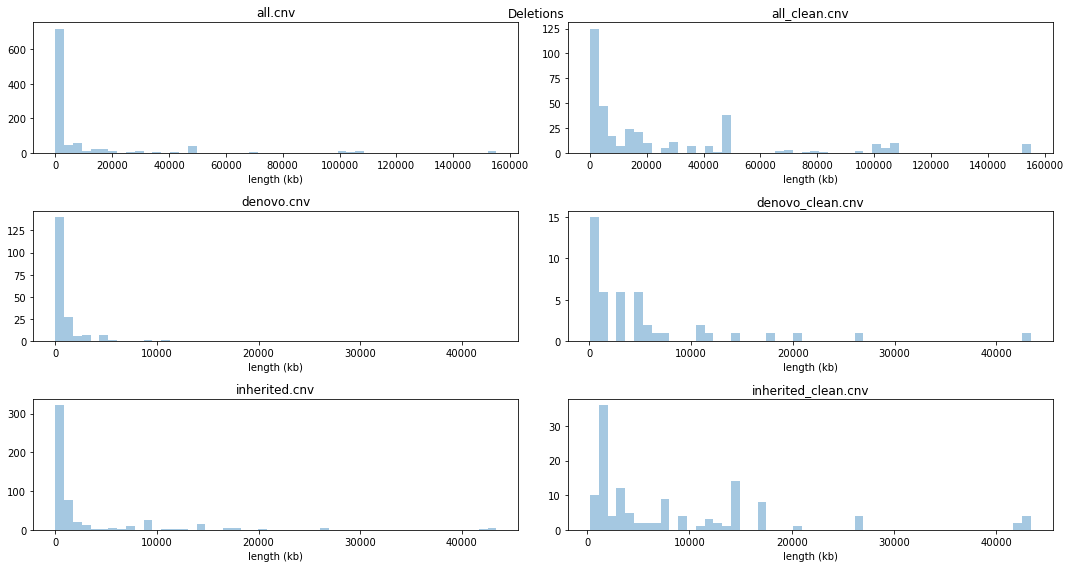

In [8]:
data_dir = '/home/sudregp/data/cnv/cnvkit/'
files = glob.glob(data_dir + '/*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        df = df[df[5] == 1]
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.suptitle('Deletions')
plt.tight_layout()

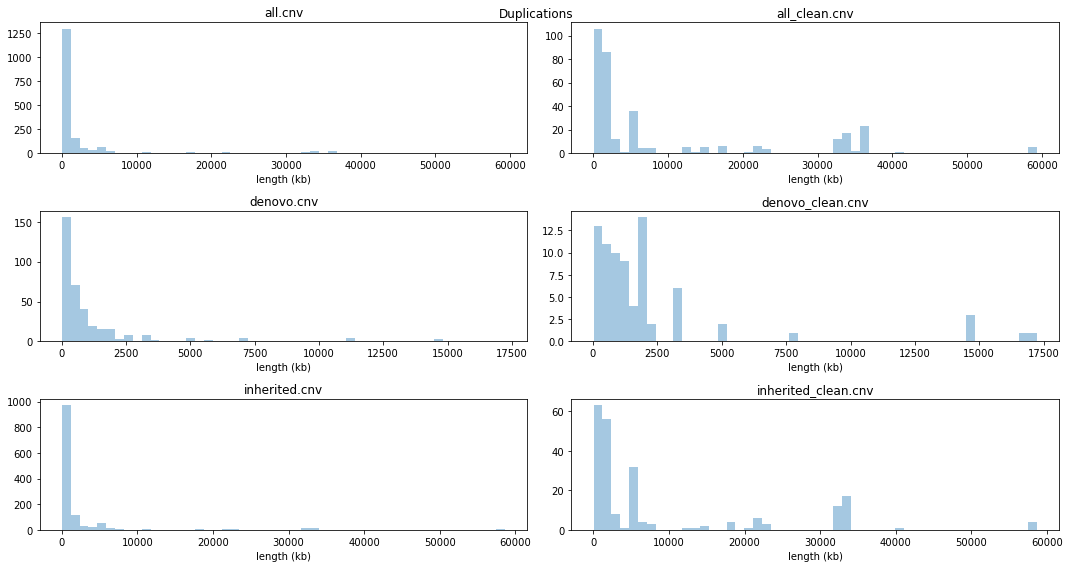

In [10]:
data_dir = '/home/sudregp/data/cnv/cnvkit/'
files = glob.glob(data_dir + '/*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        df = df[df[5] == 3]
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.suptitle('Duplications')
plt.tight_layout()

In [12]:
%%bash
cd ~/data/cnv/cnvkit
cat denovo_clean.cnv | awk '{ if ((($5-$4)/1000 > 12500) && $6 == 3) { print $_, ($5-$4)/1000 } }'

   1976   CLIA_400201    5     17518369     34190767      3            0        0  16672.4
  10128   CLIA_400153    3     75679820     90306533      3            0        0  14626.7
  10128   CLIA_400152    3     75679820     90306533      3            0        0  14626.7
  10094   CLIA_400144    3     75679820     90306533      3            0        0  14626.7
  10094   CLIA_400144    7     57085422     74329451      3            0        0  17244


In [13]:
print 'CLIA_400201' in affected
print 'CLIA_400153' in affected
print 'CLIA_400152' in affected
print 'CLIA_400154' in affected

False
True
False
False


Yep, still nothing. Maybe if we look into the gene-based analysis?

# TODO

* analyze data
* try other options for reference (see above)
* try with one of the aligners suggested in the CNVkit page